# Deep Learning Tutorial 2: Training

In [1]:
import numpy as np
np.random.seed(42)

from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import SVG


from callbacks import AUCHistory

Using Theano backend.


## Preparation

### Loading our data

Data has been saved in a file named *data.npz*. It can be loaded using *np.load* and then behaves similar to a Python dictionary, where they keys *records* and *labels* corresponds to a numpy array for our input data and our labels, respectively.

In [2]:
saved = np.load("data.npz")
data = saved["records"]
labels = saved["labels"]

The input data is a 3-dimensional array, where the first dimension corresponds to the number of instances, the second dimension to the number of time steps, and the third dimension to the number of features.

In [3]:
data.shape

(74574, 70, 15)

More specifically, 74574 is the number of drives in our data, 70 the number of records per drive, and 15 features per record.

In [4]:
n_drives = data.shape[0]
n_records = data.shape[1]
n_features = data.shape[2]

First, we define the input layer which just takes in our data. It does not contain any neurons other than defining the shape of our input. Since we use the functional API, this also means that all matrix shapes in the following layers will automatically be inferred.

In [5]:
input = Input(shape=(n_records, n_features), name="inputs")

Next, we add a [Masking](https://keras.io/layers/core/#masking) layer. This layer masks an input sequence by using a mask value to identify timesteps to be skipped. This is needed since we padded our sequence with vectors of zeroes in case we don't have enough observations.

In [6]:
#x = Masking()(input)
x = input

Now, the fun parts starts. We will add a LSTM layer that summarizes each drive by performing the same computation on a vector of size n_features for each n_records.

Remember the unfolding in time computation graph for an RNN

![image](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg)

where $x$ are the observations for a particular drive, e.g. $x_1$ is the first observation and $x_2$ is the second observation. In our case, we are only interested in the last output $o_n$ where $n = \text{n_records}$.

The LSTM is reset after every drive in n_drives. The output of this LSTM will be a vector of size 20. In other words, the LSTM has 20 neurons in the output layer.

In [7]:
x = LSTM(10)(x)

We're almost done! Let's wire up the 5 output neurons of the LSTM to just a single output neuron using a [Dense](https://keras.io/layers/core/#dense) layer. A Dense layer is just your regular fully connected NN layer.

We will use sigmoid as our activation function because its output lies naturally between 0 and 1, which matches our target well.

The output of the dense layer will be $\sigma(x)$, with $\sigma(x) = \frac{1}{1 + exp(-z)}$ where $z$ is just a linear combination of the LSTM output, i.e. $\sum\limits w_j x$ of the previous layer, where $w_j$ are the learnt weights from the Dense layer.

In [8]:
output = Dense(1, activation='sigmoid', name='output')(x)

Let's define the inputs and outputs of our model.

In [9]:
model = Model(input=input, output=output)

Now, we will compile our model. Here, we specify two parameters:

- optimizer: an optimizer does all the work for us. Given the input and the computed errors, it decides which direction to take. There are quite a few [optimizers available in Keras](https://keras.io/optimizers/)
- loss: the loss or objective function tells the model how well we are doing on our data. In our case, this is simply binary crossentropy, but in other cases this may be e.g. mean squared error. Note that this function needs to be differentiable because during training we need to be able to compute the weight updates. Hence, we cannot optimize for e.g. ROCAUC directly.

In [10]:
model.compile(optimizer=Nadam(), loss="binary_crossentropy")

Let's print out a nice plot of our model.

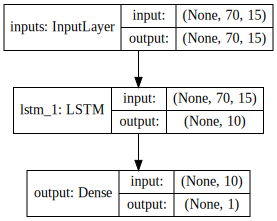

In [11]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Note that *None* simply means that the model does not really care how many instances we input.

## Let's train!

We train using a mini-batch size of 30 instances at a time. This speeds up things, because a mini-batch can be computed in parallel on a GPU. We train for three epochs, i.e. we go over our training set three times.

Conveniently, Keras will create a hold-out validation set automatically for us when giving the *validation_split* parameter. Let's set it to 20% of our data. **Please leave *verbose* at 2** in the following call, otherwise your notebook may freeze.

In [12]:
model.fit(data, labels, verbose=2, nb_epoch=3, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/3

Epoch validation AUC: 0.599408961409

17s - loss: 0.0411 - val_loss: 0.0277
Epoch 2/3

Epoch validation AUC: 0.781966847967

16s - loss: 0.0292 - val_loss: 0.0230
Epoch 3/3

Epoch validation AUC: 0.781934213934

16s - loss: 0.0284 - val_loss: 0.0223


## Task 1: Increase the number of neurons

Maybe the model is simply to small to accomodate patterns in our data.

Let's try to increase our neurons to 50.

For this task, please mark this chunk and select *Cell* and then *Run All Above*.

In [13]:
input = Input(shape=(n_records, n_features), name="inputs")
x = input
x = LSTM(20)(x)
output = Dense(1, activation='sigmoid', name='output')(x)
model1 = Model(input=input, output=output)
model1.compile(optimizer=Nadam(), loss="binary_crossentropy")

In [14]:
model1.fit(data, labels, verbose=2, nb_epoch=3, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/3

Epoch validation AUC: 0.891824397824

25s - loss: 0.1008 - val_loss: 0.0261
Epoch 2/3

Epoch validation AUC: 0.891827505828

22s - loss: 0.0262 - val_loss: 0.0238
Epoch 3/3

Epoch validation AUC: 0.891802123802

23s - loss: 0.0254 - val_loss: 0.0243


## Task 2: Add another layer

Let's make our model deeper! This is deep learning after all. Note that our network is already deep in time, i.e. we take into consideration 70 time steps.

Your task is to stack another LSTM layer on top of the layer we already have. At each time step, the first LSTM will feed into the second LSTM. This is called stacking.

Note that for this, you have to set *return_sequences=True* in the first LSTM.

In [15]:
input = Input(shape=(n_records, n_features), name="inputs")
x = input

### Your code goes here:
x = LSTM(20, return_sequences=True)(x)
x = LSTM(20)(x)
##

output = Dense(1, activation='sigmoid', name='output')(x)
model2 = Model(input=input, output=output)
model2.compile(optimizer=Nadam(), loss="binary_crossentropy")

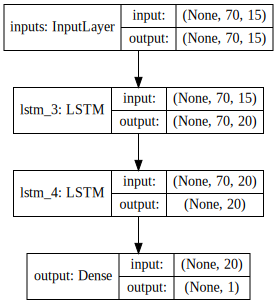

In [16]:
SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
model2.fit(data, labels, verbose=2, nb_epoch=3, batch_size=20, validation_split=0.2, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/3

Epoch validation AUC: 0.907955451955

64s - loss: 0.0300 - val_loss: 0.0219
Epoch 2/3

Epoch validation AUC: 0.901589225589

58s - loss: 0.0272 - val_loss: 0.0209
Epoch 3/3

Epoch validation AUC: 0.862738150738

58s - loss: 0.0242 - val_loss: 0.0209


## Task 3: Change the architecture

This task will be a bit more challenging. We are going to use an additional attribute: the disk's model. However, because this attribute is constant in a disks's time series, we will not add it to LSTM that summarizes the time series.

Instead, we will *merge* the $n$-dimensional vector output of the LSTM with a $m$-dimensional vector, where merging means concatenating the two vectors into a vector with dimensionality $n+m$.

Conveniently, we have already encoded the disk's model as a one-hot vector, i.e. the columns in the following matrix correspond to unique disk models and the rows to individual disks.

In [18]:
models = saved["models"]

In [19]:
models.shape

(74574, 63)

In this task, you have to do the following:

- Create a second Input with shape `(number_of_models, )`. Note that you do not need masking here because we are at this step no longer working with a time series with missing observations.
- Introduce a [Merge](https://keras.io/getting-started/sequential-model-guide/#the-merge-layer) layer that merges `[x, your_new_input]`
- Modify the `Model` instantiation to take two inputss simultaneously, similar to what you have done in the previous step.

In [29]:
input = Input(shape=(n_records, n_features), name="inputs")
input2 = Input(shape=(models.shape[1], ))

x = input
x = LSTM(20, dropout_U=0.5, return_sequences=True)(x)
x = LSTM(20, dropout_U=0.5)(x)

x2 = input2

x = merge([x, x2], mode="concat")

output = Dense(1, activation='sigmoid', name='output')(x)
model3 = Model(input=[input, input2], output=output)
model3.compile(optimizer=Nadam(), loss="binary_crossentropy")

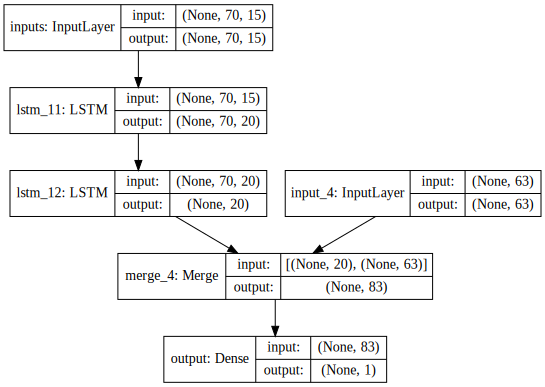

In [30]:
SVG(model_to_dot(model3, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model3.fit([data, models], labels, verbose=2, nb_epoch=5, batch_size=20, validation_split=0.2)#, callbacks=[AUCHistory()])

Train on 59659 samples, validate on 14915 samples
Epoch 1/5
